In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import bottleneck
import math 
import os
import random
import copy
import networkx as nx
import time

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def Flip(p):
    return np.random.binomial(1,p)

#%% Create connected graph with N vertices and E edges with weights between p_min and p_max

def generateRandomGraph(N, E, p_min, p_max, typ = 'gnp', degree = 3):
    
    if typ == 'rndc':
        return generateRandomConnectedGraph(N, E, p_min, p_max)
    else:
        return generateFromNx(N, p_min, p_max, typ, degree)

    
            
def generateFromNx(N, p_min, p_max, typ = 'gnp', degree = 3):
    min_degree = 0
    count = 0
    
    while min_degree < 3:
        # substitute gnp_random_graph with diff func and appropriate params
        # to generate different type of graphs 
        if typ == 'gnp':
            G  = nx.gnp_random_graph(N,1.0/np.sqrt(N), directed =False)
        if typ == 'reg':
            G = nx.random_regular_graph(degree, N)
        
        min_degree = min([d[1] for d in G.degree()])
        count += 1
        if count == 100:
            print('Failure')
            return None
    
    edges = G.edges()
    true_weights = np.zeros((N,N))
    for e in edges:
        u,v = e
        wgt = np.random.uniform(low = p_min, high=p_max)
        true_weights[u][v] = true_weights[v][u] = wgt
    print ('Total Edges', len(edges()))
    print ('Degrees', G.degree())
    print ('Min Degrees', min_degree)
    return true_weights

def generateRandomConnectedGraph(N, E, p_min, p_max):
    initialSet = set()
    visitedSet = set()
    vertices = set()
    true_weights = np.zeros((N,N))
    #generate the set of names for the vertices
    for i in range(N):
        initialSet.add(i)
        vertices.add(i)
    #set the intial vertex to be connected
    curVertex = random.sample(initialSet, 1).pop()
    initialSet.remove(curVertex)
    visitedSet.add(curVertex)
    #loop through all the vertices, connecting them randomly
    while initialSet:
        adjVertex = random.sample(initialSet, 1).pop()
        true_weights[curVertex, adjVertex] = true_weights[adjVertex, curVertex] = np.random.uniform(low = p_min, high=p_max)
        initialSet.remove(adjVertex)
        visitedSet.add(adjVertex)
        curVertex = adjVertex
    while E > N - 1:
        firstVertex = np.random.randint(0, N)
        secondVertex = np.random.randint(0, N)
        if firstVertex != secondVertex:
            if true_weights[firstVertex, secondVertex] == 0:
                true_weights[firstVertex, secondVertex] = true_weights[secondVertex, firstVertex] = np.random.uniform(low = p_min, high=p_max)
                E -= 1
    return true_weights
  

In [3]:
def Cascade(weights, stop_early=True):
    """ times_infection vector of size N """
    (N, _) = np.shape(weights) 
    source = np.random.randint(N)    
    infectedSet = set()
    infectedSet.add(source)
    susceptibleSet = set(range(N))
    susceptibleSet.remove(source)
    t = 0
    infections = {'start': source}
    while len(infectedSet) > 0:
        t += 1
        if t > 2 and stop_early:
            # Our algo only need the infections during the first 2 time steps, 
            # so we don't compute the rest of the cascade
            return infections
        infectedNew = set()
        for infectedVertex in infectedSet:
            infections[infectedVertex] = set()
            for susceptibleVertex in susceptibleSet:
                if Flip(weights[infectedVertex, susceptibleVertex]):
                    infectedNew.add(susceptibleVertex)
                    infections[infectedVertex].add(susceptibleVertex)
        infectedSet.clear()
        infectedSet.update(infectedNew)
        susceptibleSet.difference_update(infectedSet)
    return infections
    
def Mixture(weights1, weights2, alpha=0.5, stop_early=True):
    if Flip(alpha):
        return Cascade(weights1, stop_early), 1
    else:
        return Cascade(weights2, stop_early), 2

def MultipleCascades(weights, n_cascades, stop_early=True):
    mat_cascades = []
    for i_cascade in range(n_cascades):
        if ((i_cascade % 100000) == 0):
            print "cascade", i_cascade
        infections= Cascade(weights, stop_early)
        mat_cascades.append(infections)
    return mat_cascades

def MultipleCascadesOnMixture(weights1, weights2, n_cascades, alpha=0.5, stop_early=True, debug=False):
    mat_cascades = []
    mixture = []
    for i_cascade in range(n_cascades):
        if (debug and ((i_cascade % 100000) == 0)):
            print "cascade", i_cascade
        infections, mix = Mixture(weights1, weights2, alpha, stop_early)
        mat_cascades.append(infections)
        mixture.append(mix)
    return mat_cascades, mixture

In [4]:
def getTrueValue(N, weights1, weights2):
    X = (weights1 + weights2)/2
    Y = np.zeros((N,N,N))
    for i in xrange(N):
        for j in xrange(N):
            for k in xrange(N):
                if j != k and j!= i:
                    Y[i,j,k] = (weights1[i,j]*weights1[i,k] \
                                + weights2[i,j]*weights2[i,k])/2
    return X, Y

In [5]:
def getEstimators(N, cascades, X0 = None, Y0 = None, count0 = None):
    X = np.zeros((N,N))
    Y = np.zeros((N,N,N))
    if (X0 is None) or (Y0 is None) or (count0 is None):
        count = np.zeros(N) 
    else:
        count = copy.deepcopy(count0)
        for i in range(N):
            X[i,:] = X0[i,:] * float(count[i])  
            Y[i,:,:] = Y0[i,:,:] * float(count[i])

    
    for cascade in cascades:
        source = cascade['start']
        count[source] += 1
        for a in cascade[source]:
            X[source, a] += 1
            for b in cascade[source]:
                if a != b:
                    Y[source, a, b] += 1
    count[count==0] = 1.
    
     
    for i in range(N):
        X[i,:] /= float(count[i])  
        Y[i,:,:] /= float(count[i]) 
        
    return X, Y, count
    

In [6]:
def learnEdges(X):
    edges = (X > 0).astype(int)
    return edges

def createNeighbors(N, edges):
    neighbors = []; degrees = []
    for i in range(N):
        neighbors.append([j for j in range(N) if edges[i,j] == 1 or edges[j,i] == 1])
        degrees.append(len(neighbors[i]))
    return neighbors, degrees 

In [7]:
def learnStarEdge(u, a, b, c, s, X, Y):
    val = (Y[u,a,b] - X[u,a]*X[u,b])* (Y[u,a,c] - X[u,a]*X[u,c])/(Y[u,b,c] - X[u,b]*X[u,c])
    val = max(0, val)
    p = min(1, X[u,a] + s * math.sqrt(val))
    q = min(1, X[u,a] - s * math.sqrt(val))
    return p, q

def learnStarNode(u, a, neighbors, X, Y, weightsP, weightsQ, signs):
    rel_neighbors = [i for i in neighbors[u] if i!=a]
    num_neighbors = len(rel_neighbors)
    s = signs[u][a]
    (weightsP[u][a], weightsQ[u][a]) = learnStarEdge(u, a, rel_neighbors[0], rel_neighbors[1], s, X, Y)
    for i in range(num_neighbors):
        b = rel_neighbors[i]
        c = rel_neighbors[(i+1)%num_neighbors]
        sb = s * np.sign(Y[u,a,b] - X[u,a]*X[u,b])
        signs[u][b] = sb
        signs[b][u] = sb
        (weightsP[u][b], weightsQ[u][b]) = learnStarEdge(u, b, a, c, sb, X, Y)
      

In [8]:
def learnGraph(N, X, Y):
    edges = learnEdges(X)
    (neighbors, degrees) = createNeighbors(N, edges)
    #   print degrees
    weightsP = np.zeros((N,N))
    weightsQ = np.zeros((N,N))
    signs = np.zeros((N,N))
    if 2 in degrees:
        print "Not Learning This Graph. HAS degree 2 NODE"
    else:
        order = np.argsort(degrees)
        index = 0
        explored = set()
        # keep track of nodes to be checked
        queue = [(order[0], -1)]
        # keep looping until there are nodes still to be checked
        while queue:
            # pop shallowest node (first node) from queue
            node, anchor = queue.pop(0)
            if node not in explored:
                # add node to list of checked nodes
                explored.add(node)
                if degrees[node] > 1:
                    if anchor < 0:
                        anchor = neighbors[node][0]
                        signs[node, anchor] = 1
                        signs[anchor, node] = 1
                    learnStarNode(node, anchor, neighbors, X, Y, weightsP, weightsQ, signs)

                    adjacent = neighbors[node]
                    for neighbour in adjacent:
                        queue.append((neighbour, node))
    return weightsP, weightsQ

In [9]:
def createGraph(
    numVertices = 10,
    density = 0.75,
    pMinA = 0.8,
    pMaxA = 0.9,
    pMinB = 0.4,
    pMaxB = 0.5,
    typ = 'gnp',
    degree = 3
):
    numEdges = int(density*0.5*numVertices*(numVertices-1))
    weightsA = generateRandomGraph(numVertices, numEdges, pMinA, pMaxA, typ, degree)
    weightsB = generateRandomGraph(numVertices, numEdges, pMinB, pMaxB, typ, degree)
    return weightsA, weightsB

In [10]:
tolerance = 0.2

def simulate(
    weightsA, 
    weightsB,
    numCascades_step = 10000,
    numCascades_mult = 20,
    numPath = 30,
    verbose = True
):
    avg_E_error = [[] for _ in range(numPath)]
    avg_NE_error = [[] for _ in range(numPath)]
    max_error = [[] for _ in range(numPath)]
    final_errors = []
    
    
    numVertices = weightsA.shape[0]
    edges_A = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsA[i, j] > tolerance ]
    nonedges_A = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsA[i, j] <= tolerance ]
    
    edges_B = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsB[i, j] > tolerance ]
    nonedges_B = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsB[i, j] <= tolerance ]
    
    if verbose:
        print "numVertices", numVertices, 
        print "numEdges A", len(edges_A), 
        print "numEdges B", len(edges_B)
    
    X_true, Y_true = getTrueValue(numVertices, weightsA, weightsB)
    
    for r in range(numPath):
        numCascades = 0
        X_est, Y_est, count_est = None , None, None
        
        if verbose:
            print "numpath", (r+1)
        
        for _ in range(numCascades_mult):
            numCascades += numCascades_step
            
            cascadesM, mixM = MultipleCascadesOnMixture(weightsA, weightsB, 
                                                        numCascades_step)
            
            X_est, Y_est, count_est = getEstimators(numVertices, cascadesM, 
                                         X0=X_est, Y0=Y_est, count0=count_est)
            
           
            
            weightsA_est, weightsB_est = learnGraph(numVertices, X_est, Y_est)
            
            diff_1_A = np.absolute(weightsA_est - weightsA)
            diff_1_B = np.absolute(weightsB_est - weightsB)
            diff_2_A = np.absolute(weightsB_est - weightsA)
            diff_2_B = np.absolute(weightsA_est - weightsB)
            
            max_error_1_A = np.max(diff_1_A)
            max_error_1_B = np.max(diff_1_B)

            max_error_2_A = np.max(diff_2_A)
            max_error_2_B = np.max(diff_2_B)
            
            tot_error_1_AE = np.sum([diff_1_A[i,j] 
                                    for i, j in edges_A])
            tot_error_1_BE = np.sum([diff_1_B[i,j]  
                                    for i, j in edges_B])
            
            tot_error_2_AE = np.sum([diff_2_A[i,j] 
                                    for i, j in edges_A])
            tot_error_2_BE = np.sum([diff_2_B[i,j]  
                                    for i, j in edges_B])
            
            tot_error_1_ANE = np.sum([diff_1_A[i,j] 
                                    for i, j in nonedges_A])
            tot_error_1_BNE = np.sum([diff_1_B[i,j] 
                                    for i, j in nonedges_B])
            
            tot_error_2_ANE = np.sum([diff_2_A[i,j] 
                                    for i, j in nonedges_A])
            tot_error_2_BNE = np.sum([diff_2_B[i,j] 
                                    for i, j in nonedges_B])
            
            max_error_A = max_error_1_A
            max_error_B = max_error_1_B
            tot_error_AE = tot_error_1_AE
            tot_error_BE = tot_error_1_BE
            tot_error_ANE = tot_error_1_ANE
            tot_error_BNE = tot_error_1_BNE

            if tot_error_AE + tot_error_BE > tot_error_2_AE + tot_error_2_BE:
                max_error_A = max_error_2_A
                max_error_B = max_error_2_B
                tot_error_AE = tot_error_2_AE
                tot_error_BE = tot_error_2_BE
                tot_error_ANE = tot_error_2_ANE
                tot_error_BNE = tot_error_2_BNE

            max_err = np.max([max_error_A, max_error_B], axis = 0)
            avg_err_E = (tot_error_AE + tot_error_BE)/(len(edges_A) + len(edges_B))
            avg_err_NE = (tot_error_ANE + tot_error_BNE)/(len(nonedges_A) + len(nonedges_B))
            
            if verbose:
                print "#", numCascades, 
                print "max X ", np.round(np.max(np.absolute(X_est - X_true)),3),
                print "max Y ", np.round(np.max(np.absolute(Y_est - Y_true)), 3),
                print "max ", np.round(max_err,3),
                print "avg edge ", np.round(avg_err_E,3),
                print "avg nonedge ", np.round(avg_err_NE,3)
            
            
            max_error[r].append(max_err)
            avg_E_error[r].append(avg_err_E)
            avg_NE_error[r].append(avg_err_NE)

            
        final_errors.extend(np.absolute(weightsA_est - weightsA))
        final_errors.extend(np.absolute(weightsB_est - weightsB))
        
    results = {
        'avgE': avg_E_error,
        'avgNE': avg_NE_error,
        'max': max_error,
        'hist': np.histogram(final_errors, bins = 100)
    }
    return results

In [11]:
#experiment1 plot
def fun(res, attr):
    y0 = np.mean(res[attr], axis=0)
    y1 = np.percentile(res[attr], 75, axis=0)
    y2 = np.percentile(res[attr], 25, axis=0)
    return y0, y1, y2


def plotExp1(results, numV, typ,  numCascades_step = int(10e3), numCascades_mult = 10):
    x_axis = numCascades_step*np.arange(1, numCascades_mult+1)
    m0, m1, m2 = fun(results, attr= 'max')
    a0, a1, a2 = fun(results, attr= 'avgE')
    na0, na1, na2 = fun(results, attr= 'avgNE')
    
    plt.figure()
    plt.plot(x_axis, m0, '.-', label = 'Max error')
    plt.fill_between(x_axis, m1, m2, alpha=0.4)
    
    plt.plot(x_axis, a0, 's-', label = 'Avg Edge error')
    plt.fill_between(x_axis, a1, a2, alpha=0.4)
    
    plt.plot(x_axis, na0, 'o-', label = 'Avg Non-Edge error')
    plt.fill_between(x_axis, na1, na2, alpha=0.4)

    plt.legend(fontsize=15)
    plt.xlabel('Number of Samples: '+ str(numV) +' vertices', fontsize=20)
    plt.ylabel('Error', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.savefig('./Results/decay'+ typ + str(int(numV))+'.pdf', format='pdf', bbox_inches = "tight")
    plt.show()
    plt.close()
    
def plotExp3(results, numV, typ,
             numCascades_step = int(10e3), numCascades_mult = 10):
    x_axis = range(1, numCascades_mult+1)
    hist, bins = results['hist']
    hist = hist/float(sum(hist))
    hist = hist[1:]
    bins = bins[1:]
    plt.figure()
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel('Error on Edge: '+ str(numV) + ' vertices', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('./Results/hist'+ typ + str(int(numV)) +'.pdf', format='pdf', bbox_inches = "tight")
    plt.show()
    plt.close()

In [12]:
def plotExp2(err_dict, typ, scale, error_tol):
    """
    err_dict: error dictionary for different vertices
    typ: typer of graph
    scale: scale of search: searching parameter
    err_tol: error tolerance (one curve for each level)
    """
    
    numVertices = sorted(err_dict.keys())
    sample_req = np.zeros((len(numVertices), len(error_tol), 3)) #  [mean, 75, 25]
    
    print "numVertices", numVertices
    
    for i, numV in enumerate(numVertices): 
        results = err_dict[numV] 
        print 'numV', numV, 'Final error', [np.round(res[-1],2) for res in results['max']]
        for j,tol in enumerate(error_tol):
            arr = []
            for err in results['max']: # sample path
                if np.searchsorted(err[::-1], tol):
                    arr.append(len(err)- np.searchsorted(err[::-1], tol))
            sample_req[i][j] = [1000*scale[i]*np.mean(arr), 1000*scale[i]*np.percentile(arr, 75), 
                                1000*scale[i]*np.percentile(arr, 25)] 
        
    sample_req = sample_req
    print sample_req
    
    plt.figure()
    for i,tol in enumerate(error_tol):
        print 'tol', tol, 'mean', sample_req[:,i,0], 
        print '75 per', sample_req[:,i,1],  
        print '25 per', sample_req[:,i,2]
        plt.plot(numVertices, sample_req[:,i,0], '-*', label = 'error '+str(np.round(tol,3)))
        plt.fill_between(numVertices, sample_req[:,i,1], sample_req[:,i,2], alpha=0.2)
    
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.xlabel("Number of vertices", fontsize = 18)
    plt.ylabel("Num of samples" , fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig('./Results/' + typ + '_scaling.pdf', format='pdf', bbox_inches = "tight")
    
    
def plotExp5(err_dict, N, typ, scale, error_tol):
    """
    err_dict: error dictionary for different vertices
    typ: typer of graph
    scale: scale of search: searching parameter
    err_tol: error tolerance (one curve for each level)
    """
    
    numDegree = sorted(err_dict.keys())
    sample_req = np.zeros((len(numDegree), len(error_tol), 3)) #  [mean, 75, 25]
    
    print "numDegree", numDegree
    
    for i, numD in enumerate(numDegree): 
        results = err_dict[numD] 
        print 'numD', numD, 'Final error', [np.round(res[-1],2) for res in results['max']]
        for j,tol in enumerate(error_tol):
            arr = []
            for err in results['max']: # sample path
                if np.searchsorted(err[::-1], tol):
                    arr.append(len(err)- np.searchsorted(err[::-1], tol))
#                 else:
#                     arr.append(len(results['max']) + 1)
#             arr1 = np.where(np.isfinite(arr), arr, 0)
#             sample_req[i][j] = [1000*N*(np.ma.masked_invalid(arr).mean()), 0, 
#                                 0] 
            sample_req[i][j] = [1000*N*np.mean(arr), 1000*N*np.percentile(arr,75), 
                                1000*N*np.percentile(arr, 25)] 
        
    sample_req = sample_req
    print sample_req
    
    plt.figure()
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for i,tol in enumerate(error_tol):
        print 'tol', tol, 'mean', sample_req[:,i,0], 
        print '75 per', sample_req[:,i,1],  
        print '25 per', sample_req[:,i,2]
        plt.plot(numDegree, sample_req[:,i,0], '-*', label = 'error '+str(np.round(tol,3)))
        plt.fill_between(numDegree, sample_req[:,i,1], sample_req[:,i,2], alpha=0.2)
    
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.xlabel("Degree", fontsize = 18)
    plt.ylabel("Number of samples" , fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig('./Results/' + typ + '_degree.pdf', format='pdf', bbox_inches = "tight")

In [13]:
# EXPERIMENT 1: 
# Comparison of max and average error

N = 400
numCascades_step = 30000
numCascades_mult = 15
numPath = 10
weightsA, weightsB = createGraph(N, typ = 'gnp')

In [14]:
start = time.time()
results_1_gnp = simulate(weightsA, weightsB, numCascades_step, numCascades_mult, numPath, verbose = True)
plotExp1(results_1_gnp, N, 'gnp', numCascades_step, numCascades_mult)
#plotExp1(results_20_gnp, 10, 'gnp', 5000, 10)
#plotExp1(results_15_gnp, 15,'gnp', 10000, 10)
#plotExp1(results_30_gnp, 25,'gnp', 10000, 10)
#plotExp1(results_25_gnp, 25,'gnp', 20000, 10)
end = time.time()
print "Total time:", end - start

In [40]:
# EXPERIMENT 3: 
# Histogram of absolute error, 100 bins.

# plotExp3(results_5_gnp, 5, 'gnp', 5000, 10)
# plotExp3(results_10_gnp, 10, 'gnp', 5000, 10)
# plotExp3(results_15_gnp, 15,'gnp', 10000, 10)
# results_100_gnp 
# import dill
# dill.dump_session('notebook_env_degree50.db')
# dill.load_session('notebook_env_exp5.db')
plotExp3(results_1_gnp, N,'gnp')


[10 14 18 23 27 31 36 40 44 49]
('Total Edges', 250)
('Degrees', DegreeView({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 10, 42: 10, 43: 10, 44: 10, 45: 10, 46: 10, 47: 10, 48: 10, 49: 10}))
('Min Degrees', 10)
('Total Edges', 250)
('Degrees', DegreeView({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 10, 42: 10, 43: 10, 44: 10, 45: 10, 46: 10, 47: 10, 48: 10, 49: 10}))
('Min Degrees', 10)
numVertices 50 numEdges A 500 numEdges B 500
numpath 1

# 44000 max X  0.047 max Y  0.048 max  0.13 avg edge  0.023 avg nonedge  0.003
# 48000 max X  0.047 max Y  0.05 max  0.131 avg edge  0.022 avg nonedge  0.003
# 52000 max X  0.042 max Y  0.047 max  0.125 avg edge  0.021 avg nonedge  0.003
# 56000 max X  0.043 max Y  0.049 max  0.139 avg edge  0.021 avg nonedge  0.003
# 60000 max X  0.039 max Y  0.044 max  0.126 avg edge  0.02 avg nonedge  0.003
# 64000 max X  0.039 max Y  0.041 max  0.109 avg edge  0.02 avg nonedge  0.003
# 68000 max X  0.041 max Y  0.047 max  0.112 avg edge  0.019 avg nonedge  0.003
# 72000 max X  0.042 max Y  0.048 max  0.098 avg edge  0.018 avg nonedge  0.003
# 76000 max X  0.04 max Y  0.045 max  0.095 avg edge  0.018 avg nonedge  0.002
# 80000 max X  0.041 max Y  0.045 max  0.111 avg edge  0.017 avg nonedge  0.002
numpath 6
# 4000 max X  0.203 max Y  0.209 max  1.607 avg edge  0.083 avg nonedge  0.012
# 8000 max X  0.115 max Y  0.128 max  0.42 avg edge  0.053 avg nonedge  0.007
# 12000 max X  0.092 max Y  0.1 max  0

# 56000 max X  0.049 max Y  0.049 max  0.084 avg edge  0.019 avg nonedge  0.003
# 60000 max X  0.044 max Y  0.047 max  0.076 avg edge  0.019 avg nonedge  0.003
# 64000 max X  0.043 max Y  0.046 max  0.084 avg edge  0.018 avg nonedge  0.003
# 68000 max X  0.039 max Y  0.044 max  0.075 avg edge  0.017 avg nonedge  0.002
# 72000 max X  0.04 max Y  0.042 max  0.071 avg edge  0.017 avg nonedge  0.002
# 76000 max X  0.043 max Y  0.042 max  0.074 avg edge  0.017 avg nonedge  0.002
# 80000 max X  0.035 max Y  0.039 max  0.077 avg edge  0.016 avg nonedge  0.002
Total time until degree 10 : 00:13:56 
('Total Edges', 350)
('Degrees', DegreeView({0: 14, 1: 14, 2: 14, 3: 14, 4: 14, 5: 14, 6: 14, 7: 14, 8: 14, 9: 14, 10: 14, 11: 14, 12: 14, 13: 14, 14: 14, 15: 14, 16: 14, 17: 14, 18: 14, 19: 14, 20: 14, 21: 14, 22: 14, 23: 14, 24: 14, 25: 14, 26: 14, 27: 14, 28: 14, 29: 14, 30: 14, 31: 14, 32: 14, 33: 14, 34: 14, 35: 14, 36: 14, 37: 14, 38: 14, 39: 14, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14,

/Users/jessicahoffmann/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


# 4000 max X  0.199 max Y  0.205 max  1.208 avg edge  0.104 avg nonedge  0.023
# 8000 max X  0.125 max Y  0.129 max  1.336 avg edge  0.154 avg nonedge  0.043
# 12000 max X  0.114 max Y  0.123 max  0.501 avg edge  0.048 avg nonedge  0.009
# 16000 max X  0.093 max Y  0.101 max  0.512 avg edge  0.039 avg nonedge  0.008
# 20000 max X  0.105 max Y  0.104 max  0.377 avg edge  0.035 avg nonedge  0.007
# 24000 max X  0.081 max Y  0.084 max  0.293 avg edge  0.032 avg nonedge  0.006
# 28000 max X  0.071 max Y  0.075 max  0.263 avg edge  0.03 avg nonedge  0.005
# 32000 max X  0.062 max Y  0.078 max  0.199 avg edge  0.028 avg nonedge  0.005
# 36000 max X  0.057 max Y  0.071 max  0.171 avg edge  0.026 avg nonedge  0.005
# 40000 max X  0.053 max Y  0.066 max  0.145 avg edge  0.024 avg nonedge  0.005
# 44000 max X  0.048 max Y  0.064 max  0.116 avg edge  0.023 avg nonedge  0.004
# 48000 max X  0.045 max Y  0.056 max  0.122 avg edge  0.022 avg nonedge  0.004
# 52000 max X  0.053 max Y  0.058 max  0.14

/Users/jessicahoffmann/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


# 4000 max X  0.159 max Y  0.17 max  inf avg edge  inf avg nonedge  inf
# 8000 max X  0.127 max Y  0.133 max  0.602 avg edge  0.057 avg nonedge  0.01
# 12000 max X  0.101 max Y  0.133 max  0.459 avg edge  0.049 avg nonedge  0.009
# 16000 max X  0.096 max Y  0.102 max  0.479 avg edge  0.041 avg nonedge  0.008
# 20000 max X  0.088 max Y  0.081 max  0.255 avg edge  0.035 avg nonedge  0.006
# 24000 max X  0.098 max Y  0.085 max  0.253 avg edge  0.031 avg nonedge  0.006
# 28000 max X  0.093 max Y  0.079 max  0.266 avg edge  0.029 avg nonedge  0.005
# 32000 max X  0.091 max Y  0.078 max  0.289 avg edge  0.026 avg nonedge  0.005
# 36000 max X  0.086 max Y  0.078 max  0.22 avg edge  0.025 avg nonedge  0.005
# 40000 max X  0.074 max Y  0.07 max  0.204 avg edge  0.024 avg nonedge  0.005
# 44000 max X  0.074 max Y  0.068 max  0.201 avg edge  0.023 avg nonedge  0.005
# 48000 max X  0.067 max Y  0.065 max  0.152 avg edge  0.022 avg nonedge  0.004
# 52000 max X  0.061 max Y  0.062 max  0.144 avg edg

# 16000 max X  0.1 max Y  0.111 max  0.209 avg edge  0.038 avg nonedge  0.008
# 20000 max X  0.078 max Y  0.095 max  0.232 avg edge  0.034 avg nonedge  0.007
# 24000 max X  0.078 max Y  0.076 max  0.295 avg edge  0.031 avg nonedge  0.006
# 28000 max X  0.059 max Y  0.068 max  0.268 avg edge  0.029 avg nonedge  0.006
# 32000 max X  0.067 max Y  0.069 max  0.172 avg edge  0.027 avg nonedge  0.005
# 36000 max X  0.059 max Y  0.066 max  0.18 avg edge  0.025 avg nonedge  0.005
# 40000 max X  0.061 max Y  0.068 max  0.213 avg edge  0.024 avg nonedge  0.005
# 44000 max X  0.064 max Y  0.071 max  0.148 avg edge  0.022 avg nonedge  0.005
# 48000 max X  0.052 max Y  0.058 max  0.144 avg edge  0.021 avg nonedge  0.004
# 52000 max X  0.048 max Y  0.054 max  0.155 avg edge  0.021 avg nonedge  0.004
# 56000 max X  0.043 max Y  0.048 max  0.128 avg edge  0.02 avg nonedge  0.004
# 60000 max X  0.041 max Y  0.045 max  0.118 avg edge  0.019 avg nonedge  0.004
# 64000 max X  0.042 max Y  0.049 max  0.108

# 56000 max X  0.04 max Y  0.048 max  0.125 avg edge  0.021 avg nonedge  0.005
# 60000 max X  0.045 max Y  0.05 max  0.12 avg edge  0.02 avg nonedge  0.005
# 64000 max X  0.038 max Y  0.044 max  0.118 avg edge  0.02 avg nonedge  0.005
# 68000 max X  0.038 max Y  0.048 max  0.128 avg edge  0.019 avg nonedge  0.005
# 72000 max X  0.035 max Y  0.045 max  0.132 avg edge  0.018 avg nonedge  0.005
# 76000 max X  0.034 max Y  0.043 max  0.137 avg edge  0.018 avg nonedge  0.004
# 80000 max X  0.033 max Y  0.038 max  0.138 avg edge  0.017 avg nonedge  0.004
numpath 3
# 4000 max X  0.156 max Y  0.17 max  1.593 avg edge  0.092 avg nonedge  0.024
# 8000 max X  0.125 max Y  0.142 max  1.797 avg edge  0.061 avg nonedge  0.015
# 12000 max X  0.08 max Y  0.105 max  0.453 avg edge  0.048 avg nonedge  0.012
# 16000 max X  0.078 max Y  0.094 max  0.49 avg edge  0.041 avg nonedge  0.01
# 20000 max X  0.077 max Y  0.084 max  0.436 avg edge  0.037 avg nonedge  0.009
# 24000 max X  0.075 max Y  0.074 max  0.

# 68000 max X  0.048 max Y  0.05 max  0.122 avg edge  0.02 avg nonedge  0.005
# 72000 max X  0.046 max Y  0.047 max  0.113 avg edge  0.02 avg nonedge  0.005
# 76000 max X  0.041 max Y  0.044 max  0.115 avg edge  0.019 avg nonedge  0.005
# 80000 max X  0.037 max Y  0.043 max  0.122 avg edge  0.019 avg nonedge  0.005
numpath 8
# 4000 max X  0.163 max Y  0.185 max  2.489 avg edge  0.106 avg nonedge  0.03
# 8000 max X  0.119 max Y  0.122 max  1.206 avg edge  0.07 avg nonedge  0.02
# 12000 max X  0.101 max Y  0.105 max  0.376 avg edge  0.049 avg nonedge  0.012
# 16000 max X  0.081 max Y  0.09 max  0.329 avg edge  0.041 avg nonedge  0.011
# 20000 max X  0.068 max Y  0.079 max  0.313 avg edge  0.036 avg nonedge  0.01
# 24000 max X  0.07 max Y  0.087 max  0.202 avg edge  0.033 avg nonedge  0.009
# 28000 max X  0.073 max Y  0.084 max  0.17 avg edge  0.03 avg nonedge  0.008
# 32000 max X  0.062 max Y  0.071 max  0.149 avg edge  0.028 avg nonedge  0.007
# 36000 max X  0.062 max Y  0.066 max  0.14

# 28000 max X  0.068 max Y  0.08 max  0.35 avg edge  0.031 avg nonedge  0.01
# 32000 max X  0.063 max Y  0.069 max  0.293 avg edge  0.029 avg nonedge  0.01
# 36000 max X  0.057 max Y  0.06 max  0.201 avg edge  0.027 avg nonedge  0.009
# 40000 max X  0.054 max Y  0.061 max  0.205 avg edge  0.026 avg nonedge  0.009
# 44000 max X  0.051 max Y  0.06 max  0.196 avg edge  0.025 avg nonedge  0.008
# 48000 max X  0.051 max Y  0.056 max  0.189 avg edge  0.024 avg nonedge  0.008
# 52000 max X  0.051 max Y  0.057 max  0.182 avg edge  0.023 avg nonedge  0.008
# 56000 max X  0.05 max Y  0.057 max  0.161 avg edge  0.022 avg nonedge  0.007
# 60000 max X  0.053 max Y  0.057 max  0.138 avg edge  0.022 avg nonedge  0.007
# 64000 max X  0.046 max Y  0.053 max  0.124 avg edge  0.021 avg nonedge  0.007
# 68000 max X  0.044 max Y  0.054 max  0.125 avg edge  0.02 avg nonedge  0.007
# 72000 max X  0.044 max Y  0.047 max  0.108 avg edge  0.02 avg nonedge  0.006
# 76000 max X  0.043 max Y  0.046 max  0.106 avg 

# 40000 max X  0.049 max Y  0.064 max  0.178 avg edge  0.026 avg nonedge  0.009
# 44000 max X  0.045 max Y  0.061 max  0.168 avg edge  0.024 avg nonedge  0.008
# 48000 max X  0.044 max Y  0.053 max  0.18 avg edge  0.023 avg nonedge  0.008
# 52000 max X  0.04 max Y  0.049 max  0.159 avg edge  0.022 avg nonedge  0.008
# 56000 max X  0.042 max Y  0.052 max  0.163 avg edge  0.021 avg nonedge  0.007
# 60000 max X  0.042 max Y  0.048 max  0.135 avg edge  0.02 avg nonedge  0.007
# 64000 max X  0.047 max Y  0.045 max  0.132 avg edge  0.02 avg nonedge  0.007
# 68000 max X  0.046 max Y  0.048 max  0.116 avg edge  0.019 avg nonedge  0.007
# 72000 max X  0.043 max Y  0.05 max  0.115 avg edge  0.019 avg nonedge  0.007
# 76000 max X  0.042 max Y  0.044 max  0.107 avg edge  0.019 avg nonedge  0.007
# 80000 max X  0.041 max Y  0.04 max  0.101 avg edge  0.018 avg nonedge  0.006
numpath 8
# 4000 max X  0.191 max Y  0.184 max  3802104.312 avg edge  1653.186 avg nonedge  1408.224
# 8000 max X  0.122 max Y

# 80000 max X  0.039 max Y  0.046 max  0.103 avg edge  0.018 avg nonedge  0.008
numpath 2
# 4000 max X  0.214 max Y  0.277 max  2393572.292 avg edge  1773.11 avg nonedge  0.039
# 8000 max X  0.124 max Y  0.147 max  1.108 avg edge  0.063 avg nonedge  0.025
# 12000 max X  0.098 max Y  0.109 max  0.648 avg edge  0.049 avg nonedge  0.02
# 16000 max X  0.089 max Y  0.092 max  0.556 avg edge  0.042 avg nonedge  0.017
# 20000 max X  0.091 max Y  0.093 max  0.271 avg edge  0.038 avg nonedge  0.015
# 24000 max X  0.084 max Y  0.084 max  0.244 avg edge  0.034 avg nonedge  0.013
# 28000 max X  0.08 max Y  0.075 max  0.276 avg edge  0.032 avg nonedge  0.013
# 32000 max X  0.067 max Y  0.074 max  0.306 avg edge  0.029 avg nonedge  0.012
# 36000 max X  0.06 max Y  0.064 max  0.404 avg edge  0.028 avg nonedge  0.011
# 40000 max X  0.062 max Y  0.068 max  0.282 avg edge  0.026 avg nonedge  0.011
# 44000 max X  0.055 max Y  0.061 max  0.263 avg edge  0.025 avg nonedge  0.01
# 48000 max X  0.05 max Y  0

# 12000 max X  0.132 max Y  0.151 max  1.658 avg edge  0.052 avg nonedge  0.022
# 16000 max X  0.104 max Y  0.109 max  0.639 avg edge  0.044 avg nonedge  0.019
# 20000 max X  0.084 max Y  0.095 max  0.365 avg edge  0.038 avg nonedge  0.016
# 24000 max X  0.081 max Y  0.096 max  0.872 avg edge  0.035 avg nonedge  0.015
# 28000 max X  0.068 max Y  0.079 max  0.256 avg edge  0.031 avg nonedge  0.013
# 32000 max X  0.066 max Y  0.076 max  0.286 avg edge  0.029 avg nonedge  0.012
# 36000 max X  0.066 max Y  0.075 max  0.174 avg edge  0.027 avg nonedge  0.011
# 40000 max X  0.063 max Y  0.07 max  0.159 avg edge  0.026 avg nonedge  0.01
# 44000 max X  0.054 max Y  0.06 max  0.141 avg edge  0.025 avg nonedge  0.01
# 48000 max X  0.054 max Y  0.06 max  0.145 avg edge  0.024 avg nonedge  0.01
# 52000 max X  0.057 max Y  0.059 max  0.116 avg edge  0.023 avg nonedge  0.01
# 56000 max X  0.052 max Y  0.058 max  0.12 avg edge  0.022 avg nonedge  0.009
# 60000 max X  0.045 max Y  0.055 max  0.118 avg

# 52000 max X  0.059 max Y  0.067 max  0.155 avg edge  0.023 avg nonedge  0.012
# 56000 max X  0.053 max Y  0.066 max  0.144 avg edge  0.022 avg nonedge  0.011
# 60000 max X  0.046 max Y  0.057 max  0.128 avg edge  0.022 avg nonedge  0.011
# 64000 max X  0.04 max Y  0.053 max  0.136 avg edge  0.021 avg nonedge  0.01
# 68000 max X  0.04 max Y  0.054 max  0.126 avg edge  0.02 avg nonedge  0.01
# 72000 max X  0.04 max Y  0.054 max  0.129 avg edge  0.02 avg nonedge  0.01
# 76000 max X  0.038 max Y  0.053 max  0.113 avg edge  0.019 avg nonedge  0.009
# 80000 max X  0.039 max Y  0.049 max  0.113 avg edge  0.019 avg nonedge  0.009
numpath 2
# 4000 max X  0.237 max Y  0.235 max  inf avg edge  inf avg nonedge  inf
# 8000 max X  0.123 max Y  0.149 max  8.05 avg edge  0.102 avg nonedge  0.059
# 12000 max X  0.095 max Y  0.118 max  1.997 avg edge  0.055 avg nonedge  0.027
# 16000 max X  0.094 max Y  0.11 max  1.191 avg edge  0.046 avg nonedge  0.023
# 20000 max X  0.085 max Y  0.093 max  0.59 avg 

# 68000 max X  0.044 max Y  0.052 max  0.132 avg edge  0.02 avg nonedge  0.01
# 72000 max X  0.047 max Y  0.056 max  0.121 avg edge  0.02 avg nonedge  0.01
# 76000 max X  0.05 max Y  0.052 max  0.118 avg edge  0.019 avg nonedge  0.009
# 80000 max X  0.041 max Y  0.048 max  0.103 avg edge  0.019 avg nonedge  0.009
numpath 7
# 4000 max X  0.243 max Y  0.221 max  inf avg edge  inf avg nonedge  inf
# 8000 max X  0.13 max Y  0.145 max  1.344 avg edge  0.075 avg nonedge  0.04
# 12000 max X  0.105 max Y  0.124 max  1.412 avg edge  0.055 avg nonedge  0.027
# 16000 max X  0.093 max Y  0.105 max  0.802 avg edge  0.048 avg nonedge  0.023
# 20000 max X  0.085 max Y  0.092 max  0.868 avg edge  0.041 avg nonedge  0.02
# 24000 max X  0.071 max Y  0.09 max  2.98 avg edge  0.037 avg nonedge  0.018
# 28000 max X  0.062 max Y  0.078 max  0.972 avg edge  0.033 avg nonedge  0.016
# 32000 max X  0.062 max Y  0.079 max  0.612 avg edge  0.031 avg nonedge  0.014
# 36000 max X  0.059 max Y  0.072 max  0.187 avg

# 32000 max X  0.073 max Y  0.075 max  0.312 avg edge  0.032 avg nonedge  0.018
# 36000 max X  0.061 max Y  0.07 max  0.248 avg edge  0.03 avg nonedge  0.017
# 40000 max X  0.061 max Y  0.068 max  0.255 avg edge  0.029 avg nonedge  0.016
# 44000 max X  0.059 max Y  0.065 max  0.23 avg edge  0.027 avg nonedge  0.015
# 48000 max X  0.062 max Y  0.063 max  0.259 avg edge  0.026 avg nonedge  0.015
# 52000 max X  0.055 max Y  0.058 max  0.197 avg edge  0.025 avg nonedge  0.014
# 56000 max X  0.048 max Y  0.055 max  0.16 avg edge  0.024 avg nonedge  0.014
# 60000 max X  0.048 max Y  0.055 max  0.153 avg edge  0.023 avg nonedge  0.013
# 64000 max X  0.048 max Y  0.058 max  0.167 avg edge  0.022 avg nonedge  0.013
# 68000 max X  0.048 max Y  0.055 max  0.14 avg edge  0.022 avg nonedge  0.013
# 72000 max X  0.046 max Y  0.05 max  0.155 avg edge  0.021 avg nonedge  0.013
# 76000 max X  0.043 max Y  0.047 max  0.186 avg edge  0.021 avg nonedge  0.012
# 80000 max X  0.041 max Y  0.046 max  0.154 a

# 44000 max X  0.055 max Y  0.062 max  1.699 avg edge  0.027 avg nonedge  0.013
# 48000 max X  0.056 max Y  0.064 max  0.481 avg edge  0.026 avg nonedge  0.013
# 52000 max X  0.056 max Y  0.069 max  0.575 avg edge  0.025 avg nonedge  0.013
# 56000 max X  0.054 max Y  0.064 max  0.262 avg edge  0.024 avg nonedge  0.013
# 60000 max X  0.048 max Y  0.064 max  0.224 avg edge  0.023 avg nonedge  0.012
# 64000 max X  0.052 max Y  0.072 max  0.185 avg edge  0.022 avg nonedge  0.012
# 68000 max X  0.049 max Y  0.07 max  0.195 avg edge  0.021 avg nonedge  0.011
# 72000 max X  0.046 max Y  0.066 max  0.163 avg edge  0.021 avg nonedge  0.011
# 76000 max X  0.042 max Y  0.06 max  0.181 avg edge  0.02 avg nonedge  0.011
# 80000 max X  0.042 max Y  0.052 max  0.155 avg edge  0.02 avg nonedge  0.011
numpath 7
# 4000 max X  0.162 max Y  0.2 max  3887940.428 avg edge  2160.073 avg nonedge  0.068
# 8000 max X  0.136 max Y  0.149 max  9.322 avg edge  0.074 avg nonedge  0.049
# 12000 max X  0.104 max Y  0

# 4000 max X  0.183 max Y  0.236 max  inf avg edge  inf avg nonedge  inf
# 8000 max X  0.168 max Y  0.202 max  5.04 avg edge  0.08 avg nonedge  0.053
# 12000 max X  0.121 max Y  0.137 max  3.116 avg edge  0.064 avg nonedge  0.042
# 16000 max X  0.094 max Y  0.13 max  0.878 avg edge  0.05 avg nonedge  0.033
# 20000 max X  0.085 max Y  0.099 max  0.898 avg edge  0.044 avg nonedge  0.03
# 24000 max X  0.08 max Y  0.089 max  0.603 avg edge  0.039 avg nonedge  0.027
# 28000 max X  0.068 max Y  0.088 max  0.479 avg edge  0.036 avg nonedge  0.024
# 32000 max X  0.062 max Y  0.079 max  0.37 avg edge  0.033 avg nonedge  0.022
# 36000 max X  0.065 max Y  0.078 max  0.254 avg edge  0.031 avg nonedge  0.021
# 40000 max X  0.064 max Y  0.075 max  0.206 avg edge  0.029 avg nonedge  0.02
# 44000 max X  0.063 max Y  0.074 max  0.173 avg edge  0.028 avg nonedge  0.018
# 48000 max X  0.06 max Y  0.069 max  0.195 avg edge  0.027 avg nonedge  0.018
# 52000 max X  0.053 max Y  0.062 max  0.191 avg edge  0.

# 16000 max X  0.096 max Y  0.114 max  1.766 avg edge  0.049 avg nonedge  0.033
# 20000 max X  0.085 max Y  0.105 max  0.599 avg edge  0.042 avg nonedge  0.027
# 24000 max X  0.075 max Y  0.086 max  0.486 avg edge  0.038 avg nonedge  0.025
# 28000 max X  0.071 max Y  0.084 max  0.244 avg edge  0.035 avg nonedge  0.021
# 32000 max X  0.067 max Y  0.078 max  0.234 avg edge  0.033 avg nonedge  0.02
# 36000 max X  0.064 max Y  0.072 max  0.199 avg edge  0.031 avg nonedge  0.019
# 40000 max X  0.063 max Y  0.071 max  0.219 avg edge  0.029 avg nonedge  0.018
# 44000 max X  0.065 max Y  0.07 max  0.204 avg edge  0.028 avg nonedge  0.018
# 48000 max X  0.067 max Y  0.067 max  0.175 avg edge  0.026 avg nonedge  0.016
# 52000 max X  0.066 max Y  0.064 max  0.175 avg edge  0.025 avg nonedge  0.015
# 56000 max X  0.069 max Y  0.06 max  0.179 avg edge  0.024 avg nonedge  0.015
# 60000 max X  0.06 max Y  0.058 max  0.181 avg edge  0.023 avg nonedge  0.014
# 64000 max X  0.061 max Y  0.057 max  0.218

('Total Edges', 1100)
('Degrees', DegreeView({0: 44, 1: 44, 2: 44, 3: 44, 4: 44, 5: 44, 6: 44, 7: 44, 8: 44, 9: 44, 10: 44, 11: 44, 12: 44, 13: 44, 14: 44, 15: 44, 16: 44, 17: 44, 18: 44, 19: 44, 20: 44, 21: 44, 22: 44, 23: 44, 24: 44, 25: 44, 26: 44, 27: 44, 28: 44, 29: 44, 30: 44, 31: 44, 32: 44, 33: 44, 34: 44, 35: 44, 36: 44, 37: 44, 38: 44, 39: 44, 40: 44, 41: 44, 42: 44, 43: 44, 44: 44, 45: 44, 46: 44, 47: 44, 48: 44, 49: 44}))
('Min Degrees', 44)
numVertices 50 numEdges A 2200 numEdges B 2200
numpath 1
# 4000 max X  0.198 max Y  0.254 max  inf avg edge  inf avg nonedge  0.085
# 8000 max X  0.134 max Y  0.174 max  2.758 avg edge  0.077 avg nonedge  0.05
# 12000 max X  0.135 max Y  0.136 max  4.644 avg edge  0.065 avg nonedge  0.042
# 16000 max X  0.094 max Y  0.115 max  3.4 avg edge  0.053 avg nonedge  0.032
# 20000 max X  0.084 max Y  0.1 max  1.82 avg edge  0.045 avg nonedge  0.03
# 24000 max X  0.072 max Y  0.094 max  0.47 avg edge  0.041 avg nonedge  0.027
# 28000 max X  0.06

# 72000 max X  0.048 max Y  0.062 max  0.119 avg edge  0.022 avg nonedge  0.014
# 76000 max X  0.046 max Y  0.06 max  0.128 avg edge  0.022 avg nonedge  0.014
# 80000 max X  0.044 max Y  0.056 max  0.122 avg edge  0.021 avg nonedge  0.014
numpath 6
# 4000 max X  0.171 max Y  0.219 max  inf avg edge  inf avg nonedge  inf
# 8000 max X  0.131 max Y  0.167 max  2.951 avg edge  0.082 avg nonedge  0.06
# 12000 max X  0.11 max Y  0.127 max  1.041 avg edge  0.061 avg nonedge  0.045
# 16000 max X  0.11 max Y  0.131 max  0.769 avg edge  0.049 avg nonedge  0.034
# 20000 max X  0.084 max Y  0.103 max  0.594 avg edge  0.044 avg nonedge  0.029
# 24000 max X  0.076 max Y  0.084 max  0.441 avg edge  0.039 avg nonedge  0.026
# 28000 max X  0.07 max Y  0.075 max  1.633 avg edge  0.036 avg nonedge  0.025
# 32000 max X  0.06 max Y  0.075 max  1.123 avg edge  0.034 avg nonedge  0.024
# 36000 max X  0.058 max Y  0.08 max  0.551 avg edge  0.032 avg nonedge  0.021
# 40000 max X  0.058 max Y  0.077 max  0.969 

numpath 1
# 4000 max X  0.187 max Y  0.255 max  inf avg edge  inf avg nonedge  0.0
# 8000 max X  0.154 max Y  0.177 max  5.462 avg edge  0.099 avg nonedge  0.0
# 12000 max X  0.115 max Y  0.15 max  inf avg edge  inf avg nonedge  0.0
# 16000 max X  0.095 max Y  0.131 max  1.4 avg edge  0.074 avg nonedge  0.0
# 20000 max X  0.081 max Y  0.113 max  1.091 avg edge  0.051 avg nonedge  0.0
# 24000 max X  0.082 max Y  0.098 max  0.725 avg edge  0.044 avg nonedge  0.0
# 28000 max X  0.068 max Y  0.081 max  0.398 avg edge  0.039 avg nonedge  0.0
# 32000 max X  0.072 max Y  0.087 max  0.262 avg edge  0.036 avg nonedge  0.0
# 36000 max X  0.066 max Y  0.079 max  0.277 avg edge  0.034 avg nonedge  0.0
# 40000 max X  0.057 max Y  0.067 max  0.249 avg edge  0.032 avg nonedge  0.0
# 44000 max X  0.054 max Y  0.064 max  0.219 avg edge  0.031 avg nonedge  0.0
# 48000 max X  0.053 max Y  0.061 max  0.195 avg edge  0.029 avg nonedge  0.0
# 52000 max X  0.05 max Y  0.062 max  0.256 avg edge  0.028 avg non

# 28000 max X  0.088 max Y  0.094 max  0.305 avg edge  0.038 avg nonedge  0.0
# 32000 max X  0.083 max Y  0.096 max  0.272 avg edge  0.036 avg nonedge  0.0
# 36000 max X  0.079 max Y  0.083 max  0.261 avg edge  0.034 avg nonedge  0.0
# 40000 max X  0.066 max Y  0.078 max  0.203 avg edge  0.032 avg nonedge  0.0
# 44000 max X  0.066 max Y  0.074 max  0.209 avg edge  0.031 avg nonedge  0.0
# 48000 max X  0.064 max Y  0.072 max  0.173 avg edge  0.029 avg nonedge  0.0
# 52000 max X  0.06 max Y  0.072 max  0.188 avg edge  0.028 avg nonedge  0.0
# 56000 max X  0.055 max Y  0.067 max  0.192 avg edge  0.027 avg nonedge  0.0
# 60000 max X  0.052 max Y  0.061 max  0.197 avg edge  0.026 avg nonedge  0.0
# 64000 max X  0.048 max Y  0.057 max  0.197 avg edge  0.025 avg nonedge  0.0
# 68000 max X  0.05 max Y  0.054 max  0.183 avg edge  0.025 avg nonedge  0.0
# 72000 max X  0.048 max Y  0.056 max  0.156 avg edge  0.024 avg nonedge  0.0
# 76000 max X  0.044 max Y  0.054 max  0.142 avg edge  0.023 avg n

tol 0.5 mean [ 95000. 120000. 165000. 245000. 235000. 270000. 300000. 285000. 340000.
 380000.] 75 per [137500. 150000. 200000. 287500. 250000. 287500. 300000. 300000. 350000.
 437500.] 25 per [ 50000. 100000. 112500. 200000. 200000. 200000. 250000. 212500. 300000.
 312500.]
tol 0.4 mean [110000. 170000. 200000. 305000. 275000. 295000. 340000. 330000. 375000.
 410000.] 75 per [137500. 200000. 237500. 337500. 300000. 337500. 350000. 350000. 475000.
 450000.] 25 per [100000. 150000. 162500. 250000. 212500. 250000. 262500. 262500. 300000.
 325000.]
tol 0.2 mean [255000.         310000.         380000.         465000.
 495000.         525000.         620000.         561111.11111111
 588888.88888889 605555.55555556] 75 per [300000. 350000. 475000. 500000. 600000. 587500. 712500. 700000. 650000.
 600000.] 25 per [212500. 212500. 300000. 450000. 400000. 450000. 525000. 500000. 550000.
 550000.]
Total time: 04:54:43 


<Figure size 432x288 with 0 Axes>

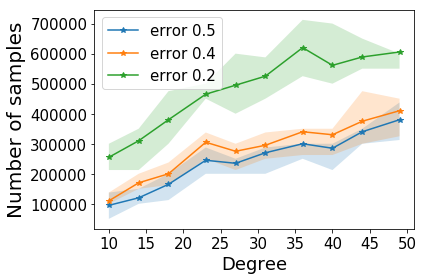

In [32]:
# # EXPERIMENT 5:
# # Vary the density of edges

# start = time.time()
# N = 50 # must be even
# numCascades_step = 4000
# numCascades_mult = 20
# numPath = 10
# numDegree = 10

# # Multiple edge density
# deg = np.linspace(10, N-1, num = numDegree, dtype = int)
# print deg
# res = []
# for d1 in deg:
#     weightsA, weightsB = createGraph(N, typ = 'reg', degree = d1)
#     results = simulate(weightsA, weightsB, numCascades_step, numCascades_mult, numPath, verbose = True)
#     res.append(results)
#     end = time.time()
#     print "\x1b[31mTotal time until degree", d1, ":", time.strftime("%H:%M:%S", time.gmtime(end - start)), "\x1b[0m"

# plotExp5({deg[i]: res[i] for i in range(numDegree)}, N, 
#          typ = 'reg', scale = deg, error_tol = [0.5, 0.4, 0.2])
# end = time.time()
# print "\x1b[31mTotal time:", time.strftime("%H:%M:%S", time.gmtime(end - start)), "\x1b[0m"

numDegree [14, 18, 23, 27, 31, 36, 40, 44, 49]
numD 14 Final error [0.09, 0.09, 0.11, 0.07, 0.09, 0.09, 0.1, 0.08, 0.1, 0.1]
numD 18 Final error [0.11, 0.14, 0.11, 0.09, 0.09, 0.13, 0.12, 0.09, 0.08, 0.12]
numD 23 Final error [0.1, 0.1, 0.11, 0.12, 0.09, 0.09, 0.1, 0.12, 0.09, 0.14]
numD 27 Final error [0.1, 0.1, 0.16, 0.13, 0.14, 0.14, 0.1, 0.12, 0.16, 0.15]
numD 31 Final error [0.11, 0.14, 0.11, 0.16, 0.14, 0.1, 0.14, 0.1, 0.11, 0.11]
numD 36 Final error [0.15, 0.15, 0.12, 0.14, 0.15, 0.16, 0.14, 0.17, 0.2, 0.12]
numD 40 Final error [0.15, 0.13, 0.12, 0.14, 0.15, 0.17, 0.13, 0.22, 0.15, 0.13]
numD 44 Final error [0.12, 0.16, 0.13, 0.12, 0.12, 0.26, 0.14, 0.12, 0.13, 0.11]
numD 49 Final error [0.12, 0.12, 0.22, 0.12, 0.14, 0.13, 0.16, 0.14, 0.14, 0.13]
[[[170000.         200000.         150000.        ]
  [185000.         200000.         150000.        ]
  [310000.         350000.         212500.        ]]

 [[200000.         237500.         162500.        ]
  [245000.         250000.

<Figure size 432x288 with 0 Axes>

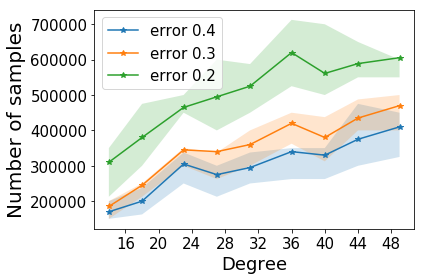

In [39]:
# plotExp5({deg[i]: res[i] for i in range(numDegree) if deg[i] > 10}, N,
#          typ = 'reg', scale = deg, error_tol = [0.4, 0.3, 0.2])
# end = time.time()
# print "Total time:", time.strftime("%H:%M:%S", time.gmtime(end - start))

In [26]:
################################################################################

# VARIOUS DEBUGGING
# Anything below is a sanity check

################################################################################

a 00:01:02


In [ ]:
# plotExp2({5: results_5_gnp, 10: results_10_gnp, 15: results_15_gnp, 20: results_20_gnp}, 
#          typ = 'gnp', scale = [5, 7.5, 10, 25], error_tol = [0.08, 0.07, 0.06, 0.05])

In [ ]:
# A = np.array([[1,0,1],[0,1,1], [1,1,1]])
# B = np.array([[0,0,1],[0,1,0], [1,0,1]])
# I = np.where(A>0, A, -1)

# print I 
# #print A[I]
# #print B[I]

In [ ]:
# print {deg[i]: res[i] for i in range(numCascades_mult)}

In [ ]:
# results_10_reg = simulate(weightsA, weightsB, numCascades_step, numCascades_mult, numPath, verbose = False)

# plotExp2({5: results_5_gnp, 10: results_10_gnp, 15: results_15_gnp, 20: results_20_gnp}, 
#          typ = 'gnp', scale = [5, 7.5, 10, 25], error_tol = [0.08, 0.07, 0.06, 0.05])